In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import Counter

def gerar_dataset_vitimas(n_vitimas=100, media_idade=35, desvio_idade=7,
                          tipo_acidente="aereo", nivel_ruido=0.05):
    """
    Gera dataset sintético de vítimas com ruído configurável.
    
    nivel_ruido: float entre 0 e 1 que controla intensidade do ruído.
                 0 -> sem ruído, 1 -> ruído máximo permitido.
                 Também define probabilidade de erro em AVPU e TRI.
    """
    np.random.seed(42)
    random.seed(42)

    dist_tri_por_tipo = {
        'aereo': {0: 0.2, 1: 0.3, 2: 0.4, 3: 0.1},
        'rodoviario': {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1},
        'ferroviario': {0: 0.3, 1: 0.3, 2: 0.3, 3: 0.1},
        'deslizamento': {0: 0.25, 1: 0.25, 2: 0.3, 3: 0.2}
    }

    faixas_fuzzy = {0:(0.93,1.0),1:(0.75,0.95),2:(0.15,0.8),3:(0.0,0.25)}

    triagem_parametros = {
        0: {'fc': (60,100), 'fr':(12,20), 'pas':(110,130), 'spo2':(96,100),
            'gcs':(15,15), 'avpu':[0], 'temp':(36.5,37.4), 'pr':[1],
            'sg':[0], 'fx':[1], 'queim':[0]},
        1: {'fc':(100,120), 'fr':(20,30), 'pas':(90,110), 'spo2':(90,95),
            'gcs':(13,14), 'avpu':[0,1], 'temp':(37.0,38.5), 'pr':[1,0],
            'sg':[1,2], 'fx':[0,1], 'queim':[0]*85+[1]*10+[2]*5},
        2: {'fc':(121,160), 'fr':(31,45), 'pas':(60,89), 'spo2':(75,89),
            'gcs':(9,12), 'avpu':[2], 'temp':(34.0,35.0), 'pr':[0],
            'sg':[3], 'fx':[1], 'queim':[0]*40+[2]*30+[3]*30},
        3: {'fc':(0,0), 'fr':(0,0), 'pas':(0,0), 'spo2':(0,74),
            'gcs':(3,6), 'avpu':[3], 'temp':(25.0,34.0), 'pr':[0],
            'sg':[3], 'fx':[0,1], 'queim':[0]*50+[3]*50}
    }

    distrib = dist_tri_por_tipo[tipo_acidente]
    classificacoes = np.random.choice(list(distrib.keys()), size=n_vitimas, p=list(distrib.values()))
    idades = np.clip(np.random.normal(media_idade, desvio_idade, n_vitimas), 0, 90).astype(int)

    dados = []

    for i in range(n_vitimas):
        tri = classificacoes[i]
        idade = idades[i]
        params = triagem_parametros[tri]
        gcs_range = params['gcs']
        gcs_value = gcs_range[0] if gcs_range[0]==gcs_range[1] else np.random.randint(*gcs_range)

        def ruido_int(val, min_val, max_val):
            delta = int((max_val - min_val + 1) * nivel_ruido)
            ruido = np.random.randint(-delta, delta+1)
            return int(np.clip(val + ruido, min_val, max_val))

        def ruido_float(val, min_val, max_val):
            delta = (max_val - min_val) * nivel_ruido
            ruido = np.random.uniform(-delta, delta)
            return float(np.clip(val + ruido, min_val, max_val))

        # --- Numéricas ---
        registro = {
            'idade': ruido_int(idade, 0, 90),
            'fc': ruido_int(np.random.randint(*params['fc']) if params['fc']!=(0,0) else 0, 0, 200),
            'fr': ruido_int(np.random.randint(*params['fr']) if params['fr']!=(0,0) else 0, 0, 50),
            'pas': ruido_int(np.random.randint(*params['pas']) if params['pas']!=(0,0) else 0, 0, 200),
            'spo2': ruido_int(np.random.randint(*params['spo2']), 0, 100),
            'temp': ruido_float(np.random.uniform(*params['temp']), 25.0, 42.0),
            'gcs': ruido_int(gcs_value, 3, 15),
            'sobr': round(ruido_float(np.random.uniform(*faixas_fuzzy[tri]),0.0,1.0),2)
        }

        # --- Categóricas ---
        # pr, sg, fx, queim
        for col in ['pr','sg','fx','queim']:
            registro[col] = random.choice(params[col])

        # --- Ruído em AVPU ---
        avpu_val = random.choice(params['avpu'])
        if random.random() < nivel_ruido:  # com probabilidade nivel_ruido, troca para outro valor
            outros = [v for v in params['avpu'] if v != avpu_val]
            if outros:
                avpu_val = random.choice(outros)
        registro['avpu'] = avpu_val

        # --- Ruído em TRI ---
        tri_val = tri
        if random.random() < nivel_ruido:
            outros = [v for v in [0,1,2,3] if v != tri_val]
            tri_val = random.choice(outros)
        registro['tri'] = tri_val

        dados.append(registro)

    df = pd.DataFrame(dados)
    df.to_csv("data_ruido_avpu_tri.csv", index=False)
    print("\nDataset salvo como data_ruido_avpu_tri.csv")

    cores = {0:'verde',1:'amarelo',2:'vermelho',3:'preto'}
    contagem = Counter(df['tri'])
    print("\nNúmero de vítimas por classificação START:")
    for k in sorted(contagem.keys()):
        print(f"  {k} ({cores[k]}): {contagem[k]}")

    plt.figure(figsize=(8,5))
    plt.hist(df['sobr'], bins=10, color='skyblue', edgecolor='black',
             weights=np.ones(n_vitimas)/n_vitimas)
    plt.title('Distribuição percentual da probabilidade de sobrevivência')
    plt.xlabel('Probabilidade de Sobrevivência')
    plt.ylabel('% de Vitimas')
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return df


Dataset salvo como data_ruido_avpu_tri.csv

Número de vítimas por classificação START:
  0 (verde): 29
  1 (amarelo): 24
  2 (vermelho): 38
  3 (preto): 9


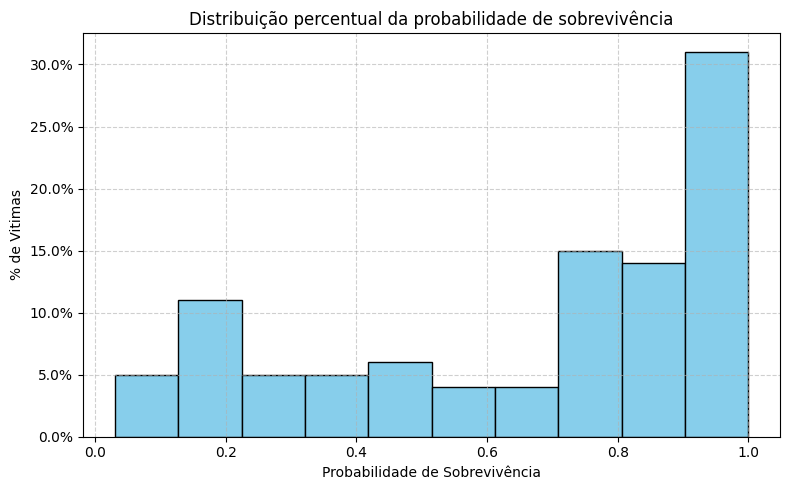

,idade,fc,fr,pas,spo2,temp,gcs,sobr,pr,sg,fx,queim,avpu,tri
0,32,104,22,113,90,37.376957,13,0.95,1,1,1,0,0,1
1,32,0,0,0,38,28.066453,4,0.19,0,3,0,0,3,3
2,35,142,32,83,84,34.199724,11,0.30,0,3,1,0,2,2
3,18,146,31,73,78,34.463619,11,0.37,0,3,1,2,2,2
4,31,86,14,109,94,37.428311,15,1.00,1,0,1,0,0,0


In [2]:
df = gerar_dataset_vitimas()
df.head()

In [3]:
df.drop(columns=["gcs","avpu"]) 

,idade,fc,fr,pas,spo2,temp,sobr,pr,sg,fx,queim,tri
0,32,104,22,113,90,37.376957,0.95,1,1,1,0,1
1,32,0,0,0,38,28.066453,0.19,0,3,0,0,3
2,35,142,32,83,84,34.199724,0.30,0,3,1,0,2
3,18,146,31,73,78,34.463619,0.37,0,3,1,2,2
4,31,86,14,109,94,37.428311,1.00,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,30,109,28,81,85,37.614065,0.90,0,2,0,0,1
96,31,154,39,81,80,33.495248,0.58,0,3,1,0,2
97,38,103,26,108,89,38.044378,0.81,1,2,0,0,1
98,35,57,16,122,94,36.124392,0.98,1,0,1,0,0


In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ["tri","sobr"])
#Para regressao
Ysob = df["sobr"]
#para classificacao
Ytri = df["tri"]

Xsob_train,Xsob_test,Ysob_train,Ysob_test = train_test_split(X,Ysob,test_size=0.2)

Xtri_train,Xtri_test,Ytri_train,Ytri_test = train_test_split(X,Ytri,test_size=0.2)


In [5]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

#parametros
k_folds = 17
num_param = 3
max_depth = [2, 4, 16]
min_samples_leaf = [0.25, 0.02, 0.01]

#salva os dados do modelo
best_model = []     
model = []          
train_scores = []   
vld_scores = []     
best_index = []     
mse = []            
bias_list = []      
val_std = []        
train_mean = []     
vld_mean = []       


#testes de parametrizacao
for i in range(num_param):
    dt = DecisionTreeRegressor(
        max_depth=max_depth[i],
        min_samples_leaf=min_samples_leaf[i],
        random_state=42
    )

    #validacao
    cv_resultados = cross_validate(
        dt, X, Ysob,
        cv=k_folds,
        scoring="neg_mean_squared_error",     
        return_train_score=True,
        return_estimator=True
    )

    #adiciona na lista
    train_scores.append(cv_resultados["train_score"])
    vld_scores.append(cv_resultados["test_score"])
    bias = np.abs(train_scores[i] - vld_scores[i])      
    bias_list.append(bias)
    best_index.append(np.argmax(vld_scores[i]))         
    best_model.append(cv_resultados["estimator"][best_index[i]])
    model.append(cv_resultados["estimator"])
    train_mean.append(float(train_scores[i].mean()))
    vld_mean.append(float(vld_scores[i].mean()))
    val_std.append(float(vld_scores[i].std(ddof=1)))
    mse.append(float(vld_scores[i].mean()))

    #printa a parametrizacao
    print(f"Parametrization {i+1}: {model}")
    print(f"Best Index: {best_index[i]}\n")





Parametrization 1: [[DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_st

In [6]:
print("Train & Valid Scores (Neg MSE) per parametrization:")
for i in range(num_param):
    print(f"Par{i+1}\tMean\t\tVar.\t\tScores per fold")
    # ddof=1 variancia amostral
    print(f"Trn:\t{train_scores[i].mean():>8.6f}\t{train_scores[i].var(ddof=1):>8.6f}\t{train_scores[i]}")
    print(f"Vld:\t{vld_scores[i].mean():>8.6f}\t{vld_scores[i].var(ddof=1):>8.6f}\t{vld_scores[i]}")
    print(f"Dif:\t{np.abs(train_scores[i].mean() - vld_scores[i].mean()):>8.6f}\t\t\t{abs(train_scores[i] - vld_scores[i])}")
    print(f"Best index: {best_index[i]}")
    print()

Train & Valid Scores (Neg MSE) per parametrization:
Par1	Mean		Var.		Scores per fold
Trn:	-0.025512	0.000001	[-0.02630382 -0.02563018 -0.02504138 -0.02685885 -0.02667919 -0.02421669
 -0.02729675 -0.02536687 -0.02363397 -0.02509917 -0.026278   -0.02373918
 -0.02529203 -0.0260899  -0.02573953 -0.02385383 -0.0265785 ]
Vld:	-0.030487	0.000352	[-0.01248132 -0.0238618  -0.06834375 -0.01034482 -0.0061238  -0.04467161
 -0.00814347 -0.03406856 -0.053963   -0.03202921 -0.0198746  -0.05223751
 -0.02876391 -0.02682371 -0.02830171 -0.05570363 -0.01253543]
Dif:	0.004975			[0.0138225  0.00176838 0.04330237 0.01651403 0.02055538 0.02045492
 0.01915328 0.00870169 0.03032904 0.00693004 0.0064034  0.02849833
 0.00347188 0.00073381 0.00256218 0.0318498  0.01404307]
Best index: 4

Par2	Mean		Var.		Scores per fold
Trn:	-0.009889	0.000001	[-0.01072573 -0.00996198 -0.00873946 -0.01066575 -0.00984726 -0.01032025
 -0.01052757 -0.00937259 -0.00863493 -0.01038734 -0.01037895 -0.0105631
 -0.00851299 -0.00920465 -0

In [7]:
chosen_par = 0   #escolhe o melhor modelo e treina com o dataset todo
chosen_model_idx = best_index[chosen_par]
chosen_model = best_model[chosen_par]


chosen_model.fit(X, Ysob)

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,0.25
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [8]:
from sklearn.metrics import mean_squared_error

In [10]:
#y_pred = chosen_model.predict(x)

#mse  = -mean_squared_error()

#print(f"MSE Negativo : {mse:.6f}")


In [ ]:
final_model = Pipeline([   #treina o melhor modelo com o dataset todo
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes[melhor_param],
        alpha=alpha[melhor_param],
        learning_rate_init=learning_rate_init[melhor_param],
        max_iter=1000,
        early_stopping=True,
        random_state=42,
        solver=solver,
        momentum=momentum,
        learning_rate='adaptive',
        activation= activation
    ))    
]).fit(X, Ytri)